In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time

import qiskit
import qiskit.quantum_info as qi
# Tomography functions
from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import DensityMatrix

from qiskit import *
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.visualization import *

# Loading your IBM Quantum account(s)
IBMQ.save_account(
    '280beccbee94456a161a6cbc217e1366bc278bf60e22bd30281fa0ca5bec6e50897278ef818f3c53f6700e04b9ed32ea364195044413b7e02836a79d886b03d9',
    overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research')

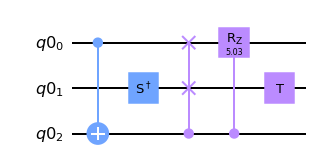

In [2]:
from qiskit.circuit.library.standard_gates import CRZGate
qr = QuantumRegister(3)
circuit = QuantumCircuit(qr)
circuit.cnot(0,2)
circuit.sdg(1)
circuit.cswap(2,1,0)
circuit.crz(5.03,2,0)
circuit.t(1)

circuit.draw(output='mpl')

In [3]:
vector = qi.Statevector.from_instruction(circuit)
tomo_circuit = state_tomography_circuits(circuit, circuit.qubits);

c:\python-interpreters\lib\site-packages\qiskit\ignis\verification\tomography\basis\circuits.py:468: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  prep += circuit
c:\python-interpreters\lib\site-packages\qiskit\circuit\quantumcircuit.py:942: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)
c:\python-interpreters\lib\site-packages\qiskit\ignis\verification\tomography\basis\circuits.py:478: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circ = prep + meas
c:\python-interpreters\lib\site-packages\qiski

In [4]:
import utility
result = utility.retrieve("Jakarta_fidelity_to_qubits_working_circuit").result()

c:\python-interpreters\lib\site-packages\qiskit\aqua\__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


Retrieved from memory


In [5]:
from Tomography import tomography

tomo_fitter_bell = StateTomographyFitter(result, tomo_circuit).fit(method='lstsq')
densitie = DensityMatrix(tomo_fitter_bell)
fidelity = tomography.calc_fidelity(DensityMatrix(tomo_fitter_bell), vector)
purity = tomography.calc_purity(DensityMatrix(tomo_fitter_bell))

print(purity,fidelity)

(0.625141145518565+3.196841504610673e-20j) 0.5583436968592849


In [6]:
from numpy.linalg import linalg

fixed_purities = 0

# Extracting the density matrix from the state tomography result
state_vector = qi.Statevector.from_instruction(circuit)
theo_matrix = DensityMatrix(state_vector)
theo_eig = linalg.eig(theo_matrix.data)
theo_eig = (theo_eig[0], theo_eig[1].T)

# Getting the most significant eigenvalue and eigenvector
max_val_theo = 0
index = 0
i = 0
for val in theo_eig[0]:
    if np.absolute(val) > np.absolute(max_val_theo):
        index = i
        max_val_theo = val
    i += 1
theo_vector = theo_eig[1][index]

# Real Vector
real_matrix = densitie
real_eig = np.linalg.eig(real_matrix)
real_eig = (real_eig[0], real_eig[1].T)

# Getting the most significant eigenvalue and eigenvector
max_val_real = 0
index = 0
i = 0
for val in real_eig[0]:
    if np.absolute(val) > np.absolute(max_val_real):
        index = i
        max_val_real = val
    i += 1
real_vector = real_eig[1][index]
real_eignval = real_eig[0][index]


dot = np.abs(np.dot(theo_vector, real_vector))**2
print("Number of qubits: ", 3)
print("Vector dot: ", dot)
print("Eigenvalue", real_eignval)
print("Purity: ", np.absolute(purity))
print("Fidelity: ", np.absolute(fidelity))

print("___")
fixed_purity = np.absolute(purity) * (dot**2)
print("Fixed purity: ", fixed_purity)
print("_____________")

Number of qubits:  3
Vector dot:  0.9508824574062984
Eigenvalue (0.783300465718823-2.0217072666561106e-18j)
Purity:  0.625141145518565
Fidelity:  0.5583436968592849
___
Fixed purity:  0.5652385254716455
_____________


In [7]:
densitie.draw('latex')

<IPython.core.display.Latex object>

In [8]:
theo_matrix.draw('latex')

<IPython.core.display.Latex object>

In [9]:
sum = 0
for i, j in zip(range(densitie.dim),range(densitie.dim)):
    sum += (densitie.data[i,j] - theo_matrix.data[i,j])**2

print("Closseness: ", sum)

Closseness:  (0.07743448256778075+0j)
